In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

# Урок 7. Классификация KNN. Кластеризация K-means.

**1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.**

In [2]:
# Из загруженного датасета берём два признака для анализа.
X, y = load_iris(return_X_y=True)
X = X[:, :2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

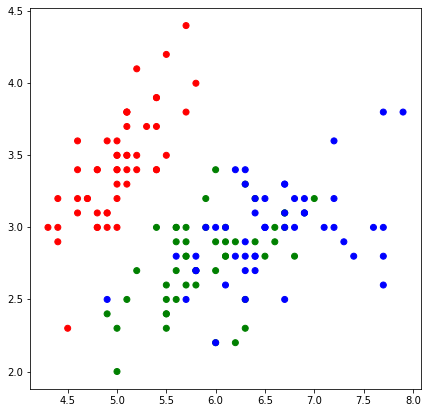

In [3]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

In [4]:
"""Евклидова метрика расстояния"""
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [5]:
"""Вычисление веса от расстояния"""
weight = lambda d: 0.5 ** d

In [6]:
"""Метрика точности"""
accuracy = lambda y, pred: sum(pred == y) / len(y)

In [7]:
"""Алгоритм поиска K ближайших соседей"""
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            # Расстояние от классифицируемого объекта до объекта из обучающей выборки
            distance = e_metrics(x, x_train[i])
                       
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем суммарные веса разных классов
        for distance, answer in sorted(test_distances)[0:k]:
            classes[answer] += weight(distance)
        
        # Записываем в список ответов класс с наибольшим весом
        answers.append(sorted(classes, key=classes.get)[-1])

    return answers

In [8]:
k = 5
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


In [9]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

C:\Users\amfet\AppData\Local\Temp/ipykernel_4992/1058702530.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


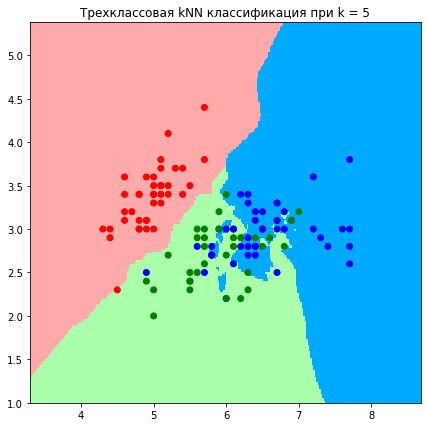

In [10]:
get_graph(X_train, y_train, k)

**2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).**

In [11]:
"""Алгоритм кластеризации kmeans"""
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [12]:
"""Средне квадратичное внутрикластерное расстояние"""
def inter_class_mean_square_distance(centroids, classes):
    result = 0

    for class_index, class_items in classes.items():
        class_square_distance = 0
        
        for x in class_items:
            distance = e_metrics(x, centroids[class_index])
            class_square_distance += distance ** 2

        result += class_square_distance / len(class_items)
        
    return result   

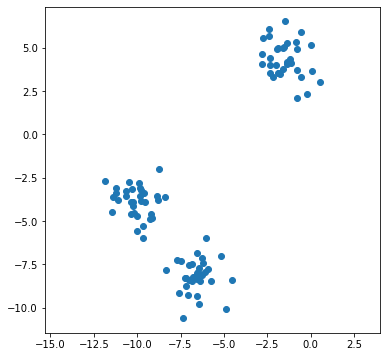

In [13]:
X, y = make_blobs(n_samples=100, random_state=1)

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.show()

In [14]:
max_iterations = 7
min_distance = 1e-4

k_list = np.arange(1, 11, 1)
msd_list = []

for k in k_list:
    centroids, classes = kmeans(X, k, max_iterations, min_distance)
    msd = inter_class_mean_square_distance(centroids, classes)
    msd_list.append(msd)

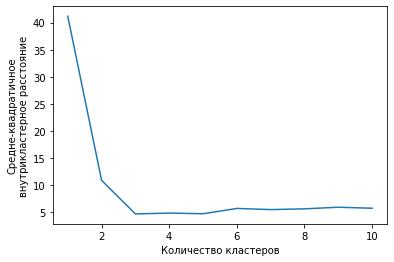

In [15]:
plt.plot(k_list, msd_list)
plt.xlabel('Количество кластеров')
plt.ylabel('Средне-квадратичное\nвнутрикластерное расстояние')
plt.show()

С увеличением числа кластеров, среднеквадратичное внутрикластерное расстояние уменьшается. Похоже что нельзя рассматривать эту метрику как критерий качества модели без учёта межкластерных расстояний.